# Suppression d'obstacles dans une série d'images

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [14]:
%load_ext line_profiler

In [4]:
from skimage.io import imread

boulangerie, leopard, danse = [],[],[]

for i in range(5):
    name_im = "boulangerie" + str(i+1)
    filename = 'boulangerie/{}.png'.format(name_im)
    boulangerie.append(imread(filename))
    name_im = "leopard" + str(i+1)
    filename = 'leopard/{}.png'.format(name_im)
    leopard.append(imread(filename))
    name_im = "danse" + str(i+1)
    filename = 'danse/{}.png'.format(name_im)
    danse.append(imread(filename))

# Méthode par la médiane

In [27]:
def median_3d(ims):
    dists = []
    for im in ims:
        dists.append(0)
        for im2 in ims:
            dists[-1] += np.linalg.norm(im2-im)**2
    indexes = np.argsort(dists)
    return indexes[0], (dists[indexes[0]]==dists[indexes[1]])        

In [35]:
##### Test avec la méthode de la médiane #####

n = len(boulangerie)
size = boulangerie[0].shape

boulangerie_med = np.zeros(size)
unicity_map = np.zeros(size)

for i in range(size[0]):
    for j in range(size[1]):
        ims = [boulangerie[k][i,j] for k in range(n)]
        med, uni = median_3d(ims)
        boulangerie_med[i,j] = boulangerie[med][i,j]
        unicity_map[i,j] = [255*uni]*3

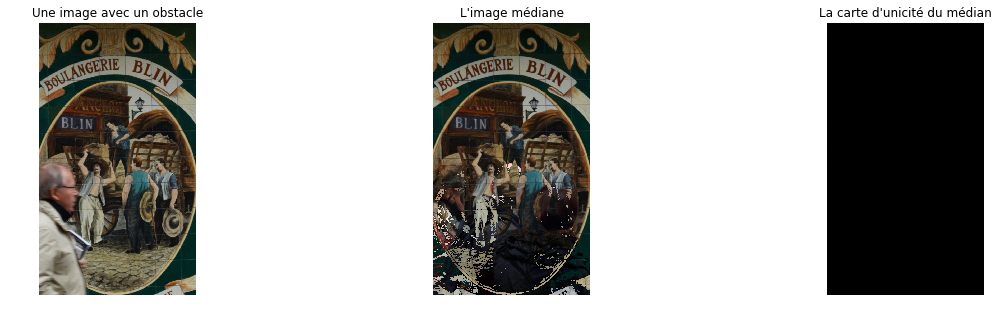

In [48]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title("Une image avec un obstacle")
plt.imshow(boulangerie[0])
plt.axis('off')
plt.subplot(132)
plt.title("L'image médiane")
plt.imshow(boulangerie_med.astype(np.uint8))
plt.axis('off')
plt.subplot(133)
plt.title("La carte d'unicité du médian")
plt.imshow(unicity_map)
plt.axis('off')

plt.show()

# Méthodes par les cliques

### Algorithme 1 : Détermination des cliques denses

In [60]:
def dense_cliques(phi, m):
    S = []
    n = len(phi)
    
    #Calcul de M
    mat=np.zeros((n,m))
    for i in range(n):
        dists = []
        for im2 in phi:
            dists.append(np.linalg.norm(im2-phi[i])**2)
        indexes = np.argsort(dists)
        mat[i] = np.sort(indexes[:m])
    
    yetToSee = range(n)
    for i in yetToSee:
        clique = []
        for j in yetToSee:
            if (np.any(mat[i]-mat[j] != 0)):
                clique.append(j)
            if (len(clique) == m):
                S.append(clique)
                yetToSee = [i for j, i in enumerate(yetToSee) if i not in clique]
    return S
    

In [59]:
%lprun -f dense_cliques dense_cliques([boulangerie[k][0,0] for k in range(n)],2)

### Algorithme 2 : Détermination des cliques "meaningful"

In [52]:
# We implement a function argminVar that returns the clique of the minimum variance :
def argminVar(S):
    if S==[]:
        return S,math.inf
    else:
        Arg=S[0]
        minVar=np.var(Arg)
        for C in S: 
            curVar=np.var(C)
            if curVar<minVar:
                Arg=C
                minVar=curVar
        return Arg, minVar

In [68]:
def meaningfulClique(phi,tresh):
    n=len(phi)
    m=2
    s=0
    Spre=[]
    Scur=[]
    while True : 
        Spre=Scur
        Scur=dense_cliques(phi,m)
        m+=1
        s=len(Scur)
        if s<2:
            break
   
    if Scur==[]:
        sigma2=math.inf
    else:
        for C in Scur:
            sigma2=np.var(C)
    
    if sigma2<=tresh:
        return Scur[0]
    else:
        Arg,minVar=argminVar(Spre)
        return Arg
        
    
        
    

### Test 

In [70]:
##### Test avec la méthode des cliques #####

n = len(boulangerie)
size = boulangerie[0].shape

boulangerie_clique = np.zeros(size)

for i in range(size[0]):
    for j in range(size[1]):
        ims = [boulangerie[k][i,j] for k in range(n)]
        true_im = meaningfulClique(ims, 2)
        boulangerie_clique[i,j] = boulangerie[true_im[0]][i,j]

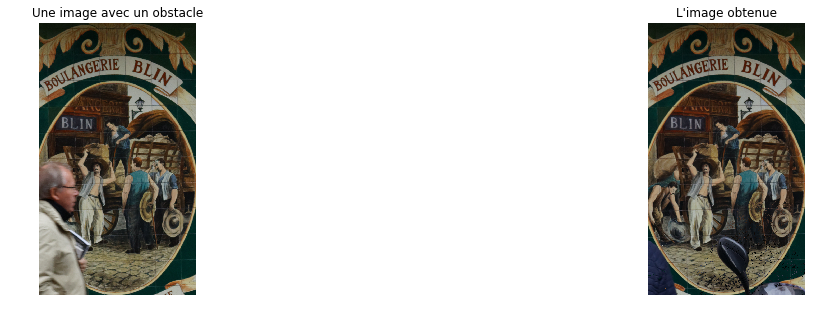

In [71]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("Une image avec un obstacle")
plt.imshow(boulangerie[0])
plt.axis('off')
plt.subplot(122)
plt.title("L'image obtenue")
plt.imshow(boulangerie_clique.astype(np.uint8))
plt.axis('off')

plt.show()

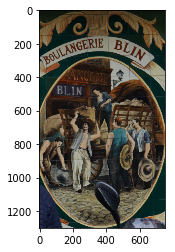

In [74]:
plt.imshow(boulangerie[1])
plt.show()